In [ ]:
!pip install numpy torch torchvision scikit-learn matplotlib tqdm seaborn pandas

In [3]:
import numpy as np
import pickle
import torch
import torchvision.datasets as ds
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd

In [4]:
# Xavier Initialization for weights
def xavier_init(input_size, output_size):
    limit = np.sqrt(6 / (input_size + output_size))
    return np.random.uniform(-limit, limit, (input_size, output_size))

In [5]:
# Layer Class (Base Class for layers)
class Layer:
    def __init__(self):
        pass

    def forward(self, input):
        raise NotImplementedError

    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError
    
    def reset_weights(self):
        pass  # Placeholder for child classes to override

In [6]:
# Dense Layer (Fully connected layer)
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.reset_weights()

    def forward(self, input):
        self.input = input
        return np.dot(self.input, self.weights) + self.bias

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(output_gradient, self.weights.T)
        weights_gradient = np.dot(self.input.T, output_gradient)
        bias_gradient = np.mean(output_gradient, axis=0)

        self.t += 1
        self.weights, self.m_w, self.v_w = Adam_update(self.weights, weights_gradient, self.m_w, self.v_w, self.t, alpha=learning_rate)
        self.bias, self.m_b, self.v_b = Adam_update(self.bias, bias_gradient, self.m_b, self.v_b, self.t, alpha=learning_rate)

        return input_gradient
    
    def reset_weights(self):
        # Reinitialize weights and bias
        self.weights = xavier_init(self.input_size, self.output_size)
        self.bias = np.zeros(self.output_size)
        self.m_w, self.v_w = np.zeros_like(self.weights), np.zeros_like(self.weights)
        self.m_b, self.v_b = np.zeros_like(self.bias), np.zeros_like(self.bias)
        self.t = 0

In [7]:
# ReLU Activation Function
class ReLU(Layer):
    def forward(self, input):
        self.input = input
        return np.maximum(0, self.input)

    def backward(self, output_gradient, learning_rate):
        return output_gradient * (self.input > 0)

In [8]:
# Softmax Layer for multi-class classification
class Softmax(Layer):
    def forward(self, input):
        exp_values = np.exp(input - np.max(input, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probabilities

    def backward(self, output_gradient, learning_rate):
        return output_gradient  # For softmax, no backward gradient update needed

In [9]:
# Adam Optimizer Update
def Adam_update(weights, gradient, m, v, t, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = beta1 * m + (1 - beta1) * gradient
    v = beta2 * v + (1 - beta2) * np.square(gradient)
    m_hat = m / (1 - np.power(beta1, t))
    v_hat = v / (1 - np.power(beta2, t))
    weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    return weights, m, v

In [10]:
# Cross-Entropy Loss Function
def cross_entropy(output, y):
    epsilon = 1e-8
    output = np.clip(output, epsilon, 1. - epsilon)
    return -np.sum(y * np.log(output)) / output.shape[0]

In [11]:
# Data Loading and Preprocessing
def preprocess(dataset):
    images = []
    labels = []
    for image, label in dataset:
        image = np.array(image).flatten() / 255.0  # Flatten and normalize to [0, 1]
        label_onehot = np.zeros(10)  # One-hot encoding
        label_onehot[label] = 1
        images.append(image)
        labels.append(label_onehot)

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [12]:
# Load Data Function
def load_data():
    train_dataset = ds.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = ds.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

    X_train, Y_train = preprocess(train_dataset)
    X_test, Y_test = preprocess(test_dataset)

    return X_train, Y_train, X_test, Y_test

In [13]:
# Accuracy, F1 Score, and Confusion Matrix Calculation
def evaluate_model(network, X_test, Y_test):
    Y_pred = []
    for i in range(0, len(X_test), 32):
        batch = X_test[i:i + 32]
        output = batch
        for layer in network:
            output = layer.forward(output)
        Y_pred.append(np.argmax(output, axis=1))
    Y_pred = np.concatenate(Y_pred)
    
    # Accuracy and F1 Score
    accuracy = accuracy_score(np.argmax(Y_test, axis=1), Y_pred)
    f1 = f1_score(np.argmax(Y_test, axis=1), Y_pred, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(np.argmax(Y_test, axis=1), Y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return accuracy, f1

In [14]:
# Training the Network
def train(network, loss_function, X_train, Y_train, X_test, Y_test, epochs=5, learning_rate=0.001, batch_size=32):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_train_acc = 0
        num_batches = X_train.shape[0] // batch_size

        # Shuffle data at the beginning of each epoch
        indices = np.random.permutation(X_train.shape[0])
        X_train = X_train[indices]
        Y_train = Y_train[indices]

        for i in range(num_batches):
            X_batch = X_train[i * batch_size:(i + 1) * batch_size]
            Y_batch = Y_train[i * batch_size:(i + 1) * batch_size]

            # Forward pass
            output = X_batch
            for layer in network:
                output = layer.forward(output)

            # Calculate loss
            batch_loss = loss_function(output, Y_batch)
            epoch_train_loss += batch_loss

            # Backward pass
            output_gradient = output - Y_batch
            for layer in reversed(network):
                output_gradient = layer.backward(output_gradient, learning_rate)

            # Calculate accuracy
            accuracy = np.mean(np.argmax(output, axis=1) == np.argmax(Y_batch, axis=1))
            epoch_train_acc += accuracy

        # Average loss and accuracy for the epoch
        train_loss.append(epoch_train_loss / num_batches)
        train_acc.append(epoch_train_acc / num_batches)

        # Validation Loss and Accuracy
        output = X_test
        for layer in network:
            output = layer.forward(output)
        batch_loss = loss_function(output, Y_test)
        val_loss.append(batch_loss)
        val_acc.append(np.mean(np.argmax(output, axis=1) == np.argmax(Y_test, axis=1)))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]*100:.2f}%, Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]*100:.2f}%")

    return train_loss, val_loss, train_acc, val_acc

In [15]:
# Plotting Loss and Accuracy
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, model_name):
    epochs = len(train_loss)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_loss, label='Train Loss', color='blue')
    plt.plot(range(epochs), val_loss, label='Validation Loss', color='red')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_acc, label='Train Accuracy', color='blue')
    plt.plot(range(epochs), val_acc, label='Validation Accuracy', color='red')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\huzza\AppData\Local\Temp\ipykernel_10008\1653589791.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image).flatten() / 255.0  # Flatten and normalize to [0, 1]


Training Model_1 with Learning Rate: 0.005
Epoch 1/20, Train Loss: 0.6581, Train Accuracy: 76.76%, Val Loss: 0.5078, Val Accuracy: 81.56%
Epoch 2/20, Train Loss: 0.4565, Train Accuracy: 83.74%, Val Loss: 0.4618, Val Accuracy: 83.43%
Epoch 3/20, Train Loss: 0.4165, Train Accuracy: 85.11%, Val Loss: 0.4347, Val Accuracy: 84.50%
Epoch 4/20, Train Loss: 0.3910, Train Accuracy: 85.96%, Val Loss: 0.4236, Val Accuracy: 84.89%
Epoch 5/20, Train Loss: 0.3709, Train Accuracy: 86.56%, Val Loss: 0.4038, Val Accuracy: 85.66%
Epoch 6/20, Train Loss: 0.3519, Train Accuracy: 87.21%, Val Loss: 0.3875, Val Accuracy: 86.18%
Epoch 7/20, Train Loss: 0.3370, Train Accuracy: 87.70%, Val Loss: 0.3776, Val Accuracy: 86.57%
Epoch 8/20, Train Loss: 0.3254, Train Accuracy: 88.20%, Val Loss: 0.3680, Val Accuracy: 86.77%
Epoch 9/20, Train Loss: 0.3144, Train Accuracy: 88.52%, Val Loss: 0.3753, Val Accuracy: 86.31%
Epoch 10/20, Train Loss: 0.3051, Train Accuracy: 88.84%, Val Loss: 0.3637, Val Accuracy: 86.93%
Epoch 

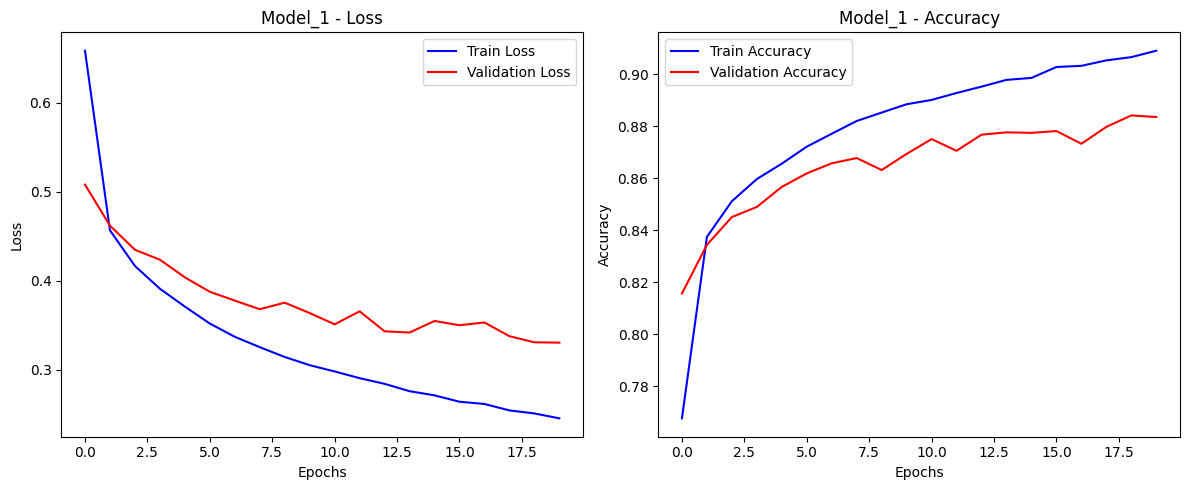

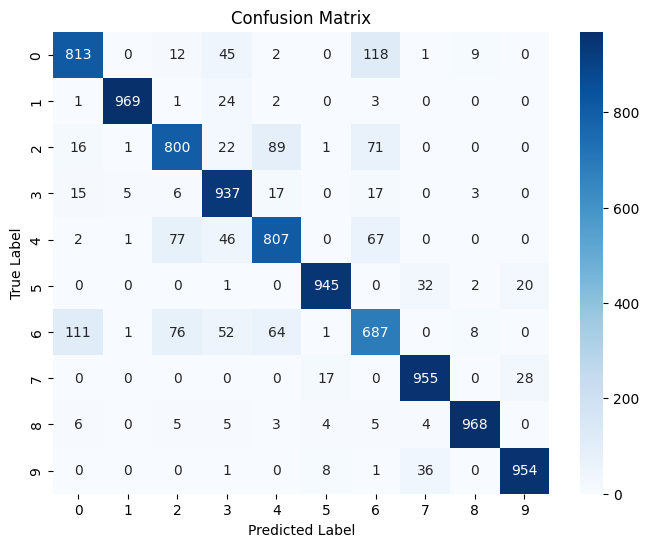

Accuracy: 88.35%, F1 Score: 0.8832
Training Model_1 with Learning Rate: 0.001
Epoch 1/20, Train Loss: 0.9645, Train Accuracy: 68.83%, Val Loss: 0.6529, Val Accuracy: 76.45%
Epoch 2/20, Train Loss: 0.5876, Train Accuracy: 78.96%, Val Loss: 0.5657, Val Accuracy: 79.76%
Epoch 3/20, Train Loss: 0.5206, Train Accuracy: 81.53%, Val Loss: 0.5205, Val Accuracy: 81.13%
Epoch 4/20, Train Loss: 0.4835, Train Accuracy: 82.84%, Val Loss: 0.4983, Val Accuracy: 82.01%
Epoch 5/20, Train Loss: 0.4592, Train Accuracy: 83.78%, Val Loss: 0.4787, Val Accuracy: 82.66%
Epoch 6/20, Train Loss: 0.4419, Train Accuracy: 84.38%, Val Loss: 0.4663, Val Accuracy: 83.20%
Epoch 7/20, Train Loss: 0.4285, Train Accuracy: 84.84%, Val Loss: 0.4541, Val Accuracy: 83.76%
Epoch 8/20, Train Loss: 0.4174, Train Accuracy: 85.28%, Val Loss: 0.4441, Val Accuracy: 83.99%
Epoch 9/20, Train Loss: 0.4082, Train Accuracy: 85.63%, Val Loss: 0.4375, Val Accuracy: 84.39%
Epoch 10/20, Train Loss: 0.3994, Train Accuracy: 85.89%, Val Loss: 

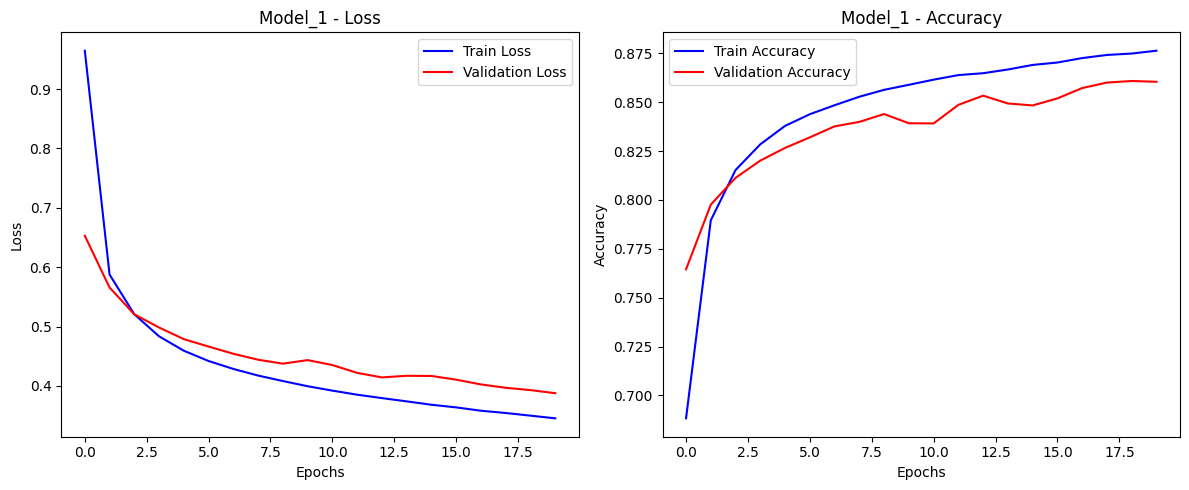

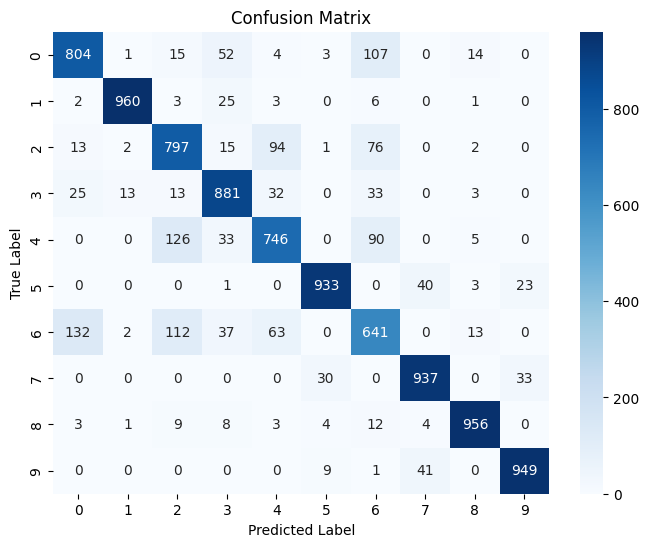

Accuracy: 86.04%, F1 Score: 0.8602
Training Model_1 with Learning Rate: 0.0005
Epoch 1/20, Train Loss: 1.2035, Train Accuracy: 64.10%, Val Loss: 0.7856, Val Accuracy: 73.39%
Epoch 2/20, Train Loss: 0.6876, Train Accuracy: 75.66%, Val Loss: 0.6482, Val Accuracy: 76.26%
Epoch 3/20, Train Loss: 0.6013, Train Accuracy: 78.31%, Val Loss: 0.5938, Val Accuracy: 78.37%
Epoch 4/20, Train Loss: 0.5552, Train Accuracy: 80.06%, Val Loss: 0.5594, Val Accuracy: 79.51%
Epoch 5/20, Train Loss: 0.5242, Train Accuracy: 81.50%, Val Loss: 0.5325, Val Accuracy: 80.76%
Epoch 6/20, Train Loss: 0.5010, Train Accuracy: 82.33%, Val Loss: 0.5183, Val Accuracy: 81.50%
Epoch 7/20, Train Loss: 0.4834, Train Accuracy: 82.92%, Val Loss: 0.5010, Val Accuracy: 82.12%
Epoch 8/20, Train Loss: 0.4696, Train Accuracy: 83.47%, Val Loss: 0.4917, Val Accuracy: 82.42%
Epoch 9/20, Train Loss: 0.4581, Train Accuracy: 83.92%, Val Loss: 0.4818, Val Accuracy: 82.61%
Epoch 10/20, Train Loss: 0.4484, Train Accuracy: 84.23%, Val Loss:

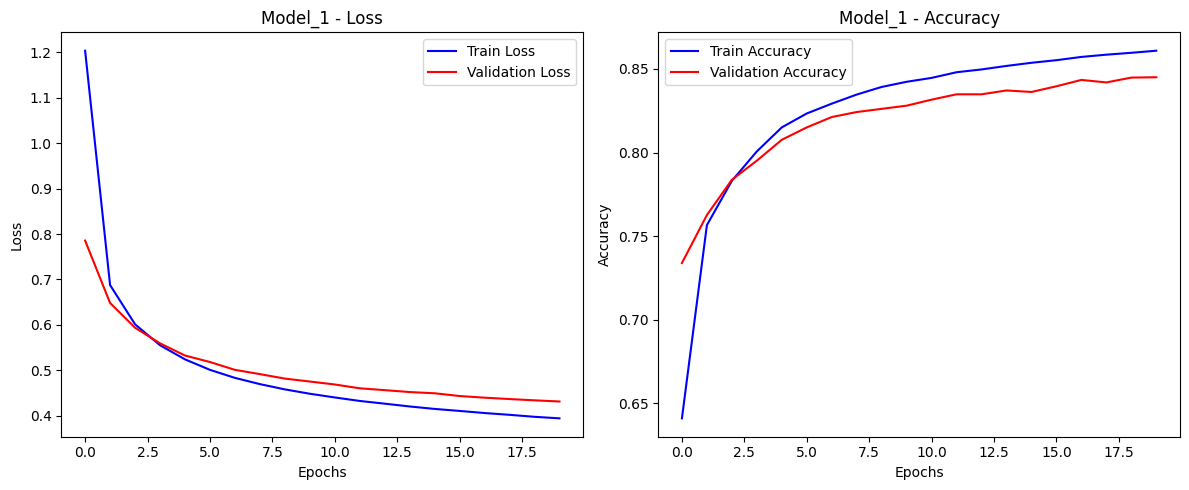

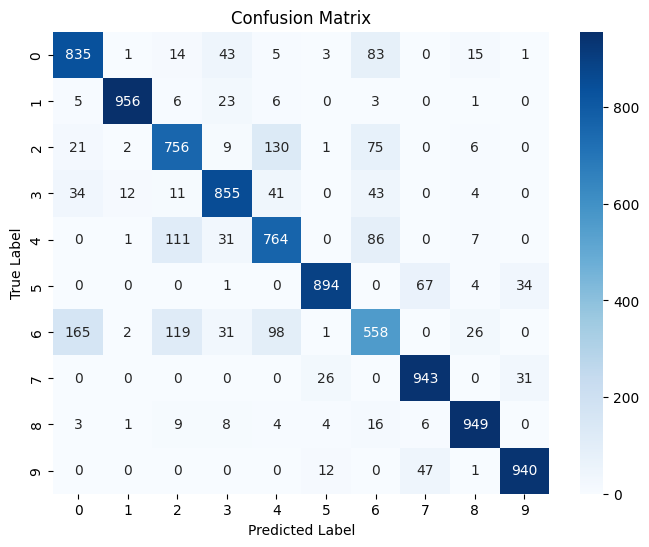

Accuracy: 84.50%, F1 Score: 0.8439
Training Model_1 with Learning Rate: 0.0001
Epoch 1/20, Train Loss: 1.8989, Train Accuracy: 58.04%, Val Loss: 1.4645, Val Accuracy: 61.26%
Epoch 2/20, Train Loss: 1.2443, Train Accuracy: 64.14%, Val Loss: 1.0905, Val Accuracy: 66.36%
Epoch 3/20, Train Loss: 0.9884, Train Accuracy: 69.81%, Val Loss: 0.9155, Val Accuracy: 70.35%
Epoch 4/20, Train Loss: 0.8543, Train Accuracy: 72.36%, Val Loss: 0.8157, Val Accuracy: 72.45%
Epoch 5/20, Train Loss: 0.7740, Train Accuracy: 73.80%, Val Loss: 0.7542, Val Accuracy: 73.80%
Epoch 6/20, Train Loss: 0.7226, Train Accuracy: 74.82%, Val Loss: 0.7137, Val Accuracy: 74.55%
Epoch 7/20, Train Loss: 0.6871, Train Accuracy: 75.59%, Val Loss: 0.6845, Val Accuracy: 75.56%
Epoch 8/20, Train Loss: 0.6605, Train Accuracy: 76.27%, Val Loss: 0.6619, Val Accuracy: 76.41%
Epoch 9/20, Train Loss: 0.6391, Train Accuracy: 77.01%, Val Loss: 0.6437, Val Accuracy: 76.89%
Epoch 10/20, Train Loss: 0.6217, Train Accuracy: 77.55%, Val Loss:

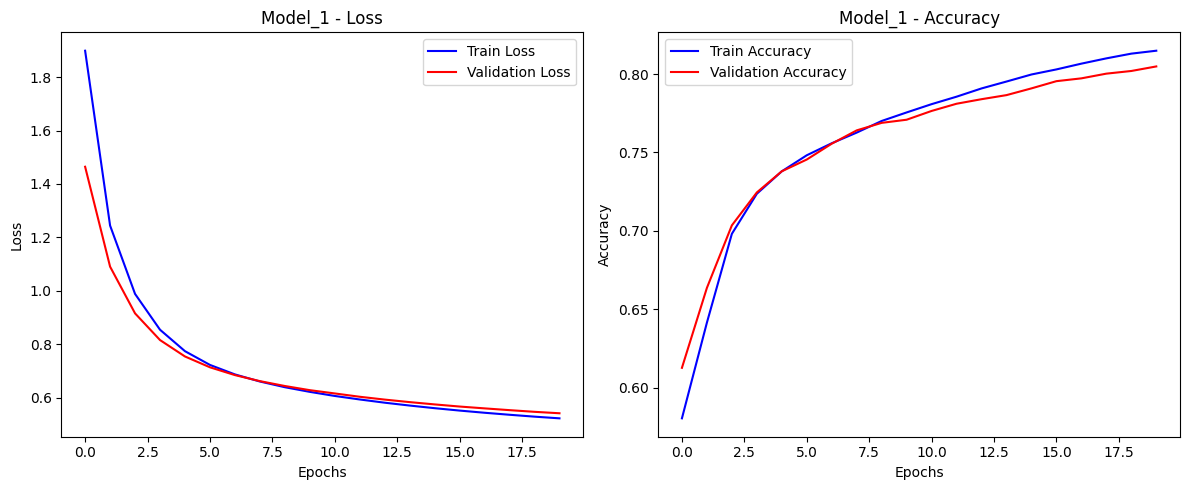

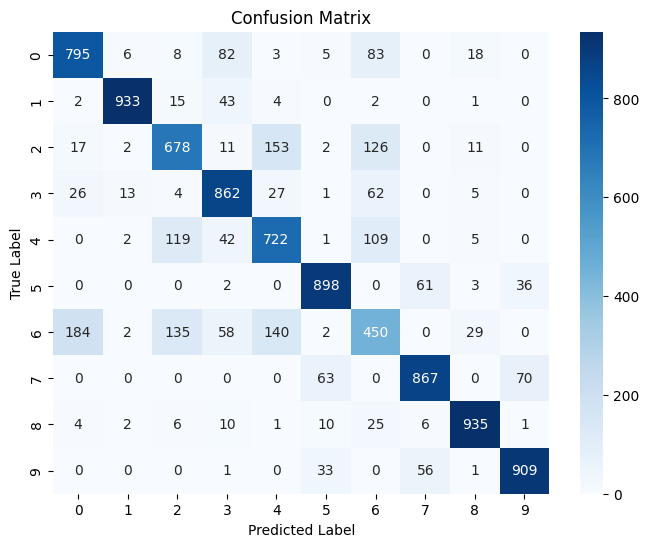

Accuracy: 80.49%, F1 Score: 0.8028
Training Model_2 with Learning Rate: 0.005
Epoch 1/20, Train Loss: 0.6426, Train Accuracy: 76.07%, Val Loss: 0.5116, Val Accuracy: 81.07%
Epoch 2/20, Train Loss: 0.4387, Train Accuracy: 84.01%, Val Loss: 0.4352, Val Accuracy: 84.28%
Epoch 3/20, Train Loss: 0.3940, Train Accuracy: 85.56%, Val Loss: 0.4097, Val Accuracy: 85.10%
Epoch 4/20, Train Loss: 0.3651, Train Accuracy: 86.46%, Val Loss: 0.3831, Val Accuracy: 86.24%
Epoch 5/20, Train Loss: 0.3460, Train Accuracy: 87.26%, Val Loss: 0.4016, Val Accuracy: 85.41%
Epoch 6/20, Train Loss: 0.3303, Train Accuracy: 87.67%, Val Loss: 0.3946, Val Accuracy: 85.79%
Epoch 7/20, Train Loss: 0.3191, Train Accuracy: 88.19%, Val Loss: 0.3632, Val Accuracy: 86.74%
Epoch 8/20, Train Loss: 0.3070, Train Accuracy: 88.63%, Val Loss: 0.3714, Val Accuracy: 86.93%
Epoch 9/20, Train Loss: 0.2992, Train Accuracy: 88.81%, Val Loss: 0.3600, Val Accuracy: 86.89%
Epoch 10/20, Train Loss: 0.2895, Train Accuracy: 89.18%, Val Loss: 

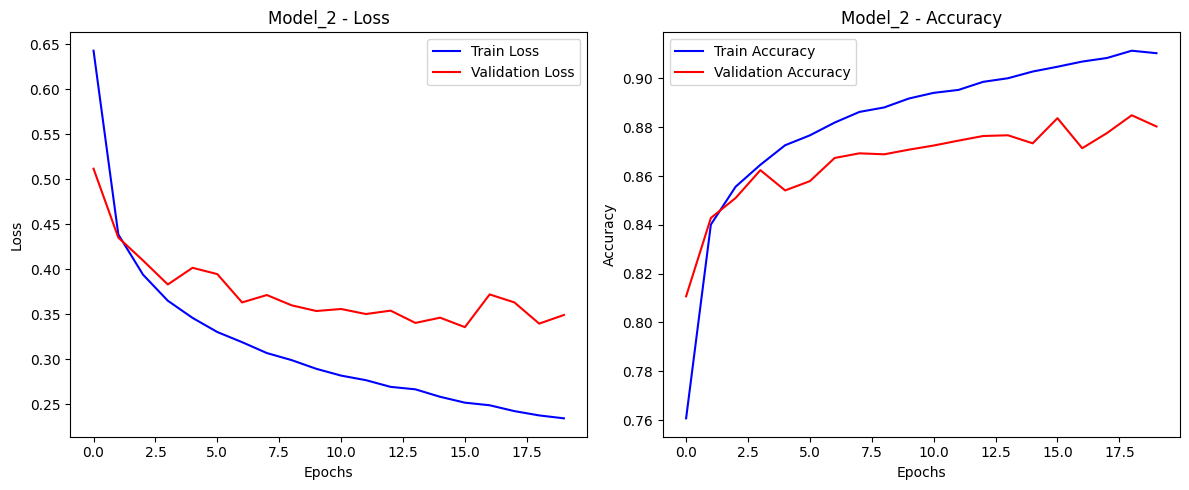

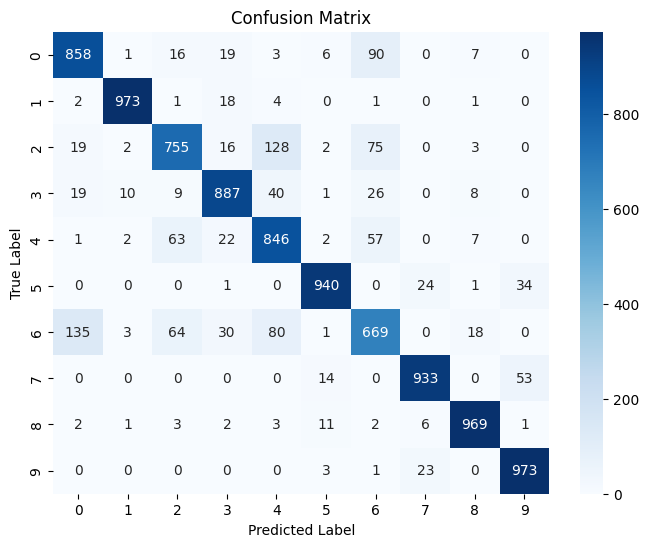

Accuracy: 88.03%, F1 Score: 0.8795
Training Model_2 with Learning Rate: 0.001
Epoch 1/20, Train Loss: 0.8153, Train Accuracy: 70.05%, Val Loss: 0.6123, Val Accuracy: 77.45%
Epoch 2/20, Train Loss: 0.5534, Train Accuracy: 79.74%, Val Loss: 0.5403, Val Accuracy: 80.45%
Epoch 3/20, Train Loss: 0.4928, Train Accuracy: 82.29%, Val Loss: 0.5202, Val Accuracy: 81.10%
Epoch 4/20, Train Loss: 0.4507, Train Accuracy: 83.83%, Val Loss: 0.4817, Val Accuracy: 82.52%
Epoch 5/20, Train Loss: 0.4226, Train Accuracy: 84.81%, Val Loss: 0.4453, Val Accuracy: 83.88%
Epoch 6/20, Train Loss: 0.4012, Train Accuracy: 85.45%, Val Loss: 0.4230, Val Accuracy: 84.70%
Epoch 7/20, Train Loss: 0.3841, Train Accuracy: 86.18%, Val Loss: 0.4233, Val Accuracy: 84.80%
Epoch 8/20, Train Loss: 0.3708, Train Accuracy: 86.54%, Val Loss: 0.4037, Val Accuracy: 85.44%
Epoch 9/20, Train Loss: 0.3581, Train Accuracy: 87.04%, Val Loss: 0.3967, Val Accuracy: 85.90%
Epoch 10/20, Train Loss: 0.3476, Train Accuracy: 87.43%, Val Loss: 

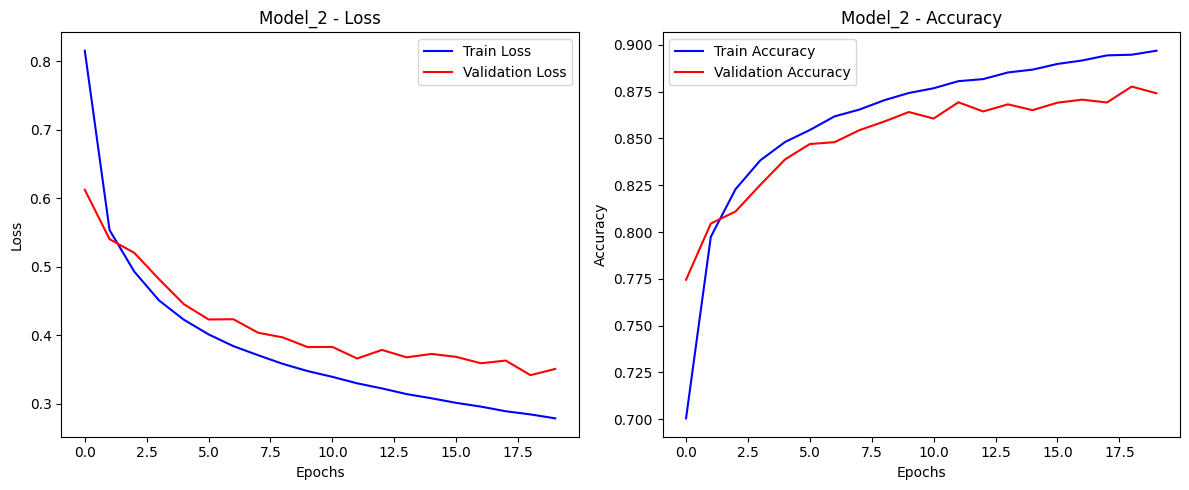

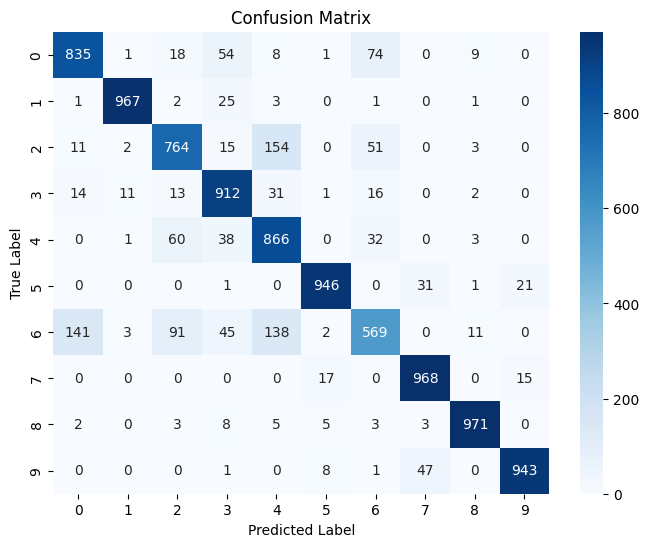

Accuracy: 87.41%, F1 Score: 0.8721
Training Model_2 with Learning Rate: 0.0005
Epoch 1/20, Train Loss: 0.9600, Train Accuracy: 65.04%, Val Loss: 0.6777, Val Accuracy: 75.19%
Epoch 2/20, Train Loss: 0.6076, Train Accuracy: 77.71%, Val Loss: 0.5967, Val Accuracy: 78.54%
Epoch 3/20, Train Loss: 0.5428, Train Accuracy: 80.36%, Val Loss: 0.5408, Val Accuracy: 80.41%
Epoch 4/20, Train Loss: 0.5022, Train Accuracy: 82.02%, Val Loss: 0.5166, Val Accuracy: 81.26%
Epoch 5/20, Train Loss: 0.4718, Train Accuracy: 83.06%, Val Loss: 0.4852, Val Accuracy: 82.35%
Epoch 6/20, Train Loss: 0.4487, Train Accuracy: 83.89%, Val Loss: 0.4677, Val Accuracy: 83.24%
Epoch 7/20, Train Loss: 0.4311, Train Accuracy: 84.49%, Val Loss: 0.4632, Val Accuracy: 83.24%
Epoch 8/20, Train Loss: 0.4182, Train Accuracy: 85.06%, Val Loss: 0.4600, Val Accuracy: 83.68%
Epoch 9/20, Train Loss: 0.4058, Train Accuracy: 85.43%, Val Loss: 0.4317, Val Accuracy: 84.36%
Epoch 10/20, Train Loss: 0.3954, Train Accuracy: 85.79%, Val Loss:

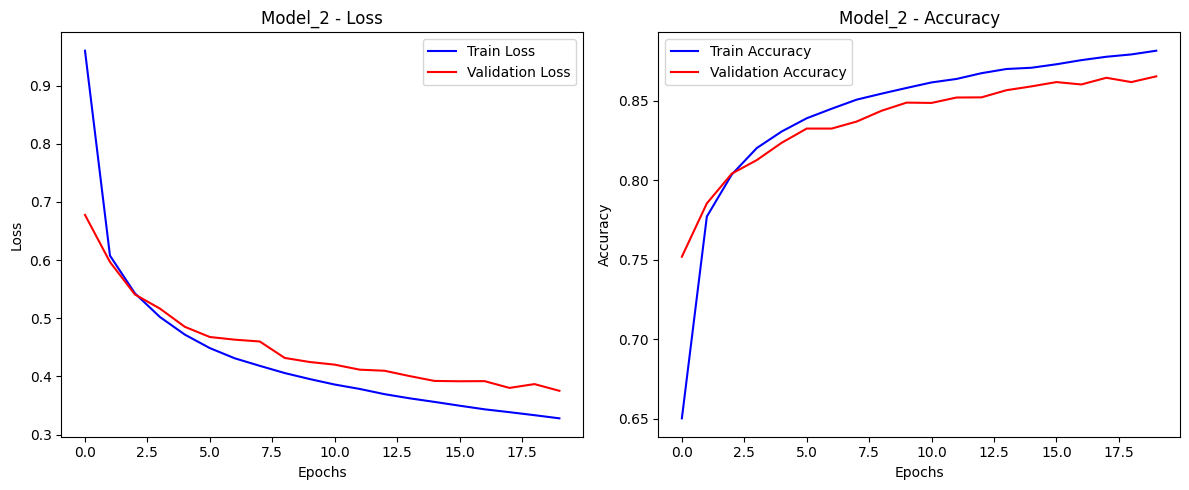

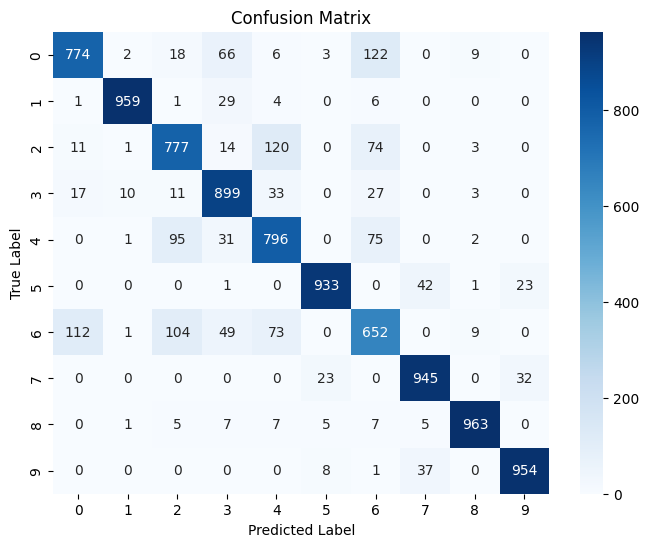

Accuracy: 86.52%, F1 Score: 0.8650
Training Model_2 with Learning Rate: 0.0001
Epoch 1/20, Train Loss: 1.4991, Train Accuracy: 52.85%, Val Loss: 1.0423, Val Accuracy: 60.44%
Epoch 2/20, Train Loss: 0.9178, Train Accuracy: 66.09%, Val Loss: 0.8371, Val Accuracy: 68.66%
Epoch 3/20, Train Loss: 0.7769, Train Accuracy: 72.01%, Val Loss: 0.7395, Val Accuracy: 73.18%
Epoch 4/20, Train Loss: 0.6987, Train Accuracy: 74.69%, Val Loss: 0.6862, Val Accuracy: 74.56%
Epoch 5/20, Train Loss: 0.6523, Train Accuracy: 76.08%, Val Loss: 0.6503, Val Accuracy: 76.26%
Epoch 6/20, Train Loss: 0.6217, Train Accuracy: 77.07%, Val Loss: 0.6239, Val Accuracy: 77.13%
Epoch 7/20, Train Loss: 0.5991, Train Accuracy: 78.01%, Val Loss: 0.6051, Val Accuracy: 77.74%
Epoch 8/20, Train Loss: 0.5802, Train Accuracy: 78.78%, Val Loss: 0.5926, Val Accuracy: 78.33%
Epoch 9/20, Train Loss: 0.5644, Train Accuracy: 79.46%, Val Loss: 0.5764, Val Accuracy: 79.09%
Epoch 10/20, Train Loss: 0.5507, Train Accuracy: 79.97%, Val Loss:

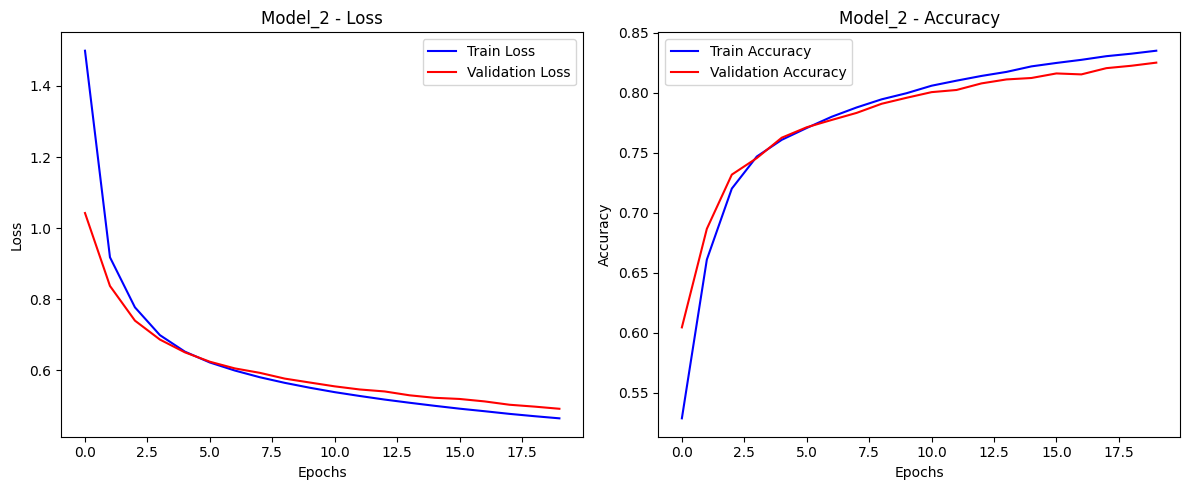

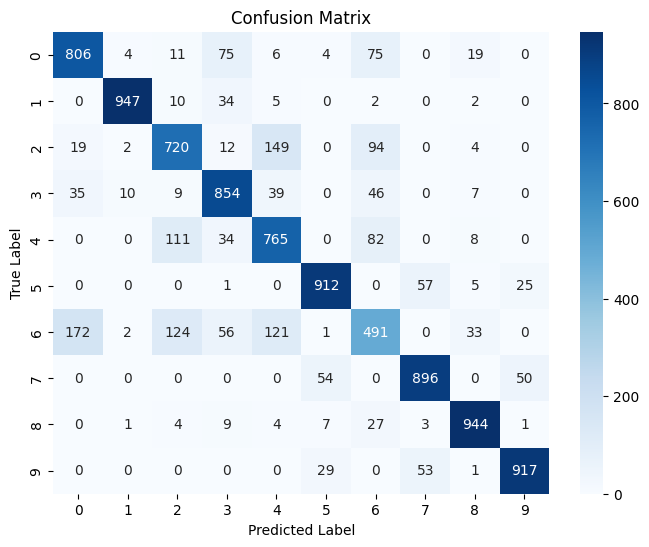

Accuracy: 82.52%, F1 Score: 0.8231
Training Model_3 with Learning Rate: 0.005
Epoch 1/20, Train Loss: 0.7142, Train Accuracy: 73.03%, Val Loss: 0.5215, Val Accuracy: 80.83%
Epoch 2/20, Train Loss: 0.4775, Train Accuracy: 82.43%, Val Loss: 0.4561, Val Accuracy: 83.21%
Epoch 3/20, Train Loss: 0.4278, Train Accuracy: 84.28%, Val Loss: 0.5134, Val Accuracy: 81.45%
Epoch 4/20, Train Loss: 0.4044, Train Accuracy: 85.10%, Val Loss: 0.4354, Val Accuracy: 83.46%
Epoch 5/20, Train Loss: 0.3801, Train Accuracy: 85.87%, Val Loss: 0.3961, Val Accuracy: 85.49%
Epoch 6/20, Train Loss: 0.3643, Train Accuracy: 86.59%, Val Loss: 0.3961, Val Accuracy: 85.43%
Epoch 7/20, Train Loss: 0.3560, Train Accuracy: 86.75%, Val Loss: 0.4328, Val Accuracy: 84.32%
Epoch 8/20, Train Loss: 0.3475, Train Accuracy: 87.09%, Val Loss: 0.3947, Val Accuracy: 85.75%
Epoch 9/20, Train Loss: 0.3363, Train Accuracy: 87.43%, Val Loss: 0.3871, Val Accuracy: 85.45%
Epoch 10/20, Train Loss: 0.3291, Train Accuracy: 87.79%, Val Loss: 

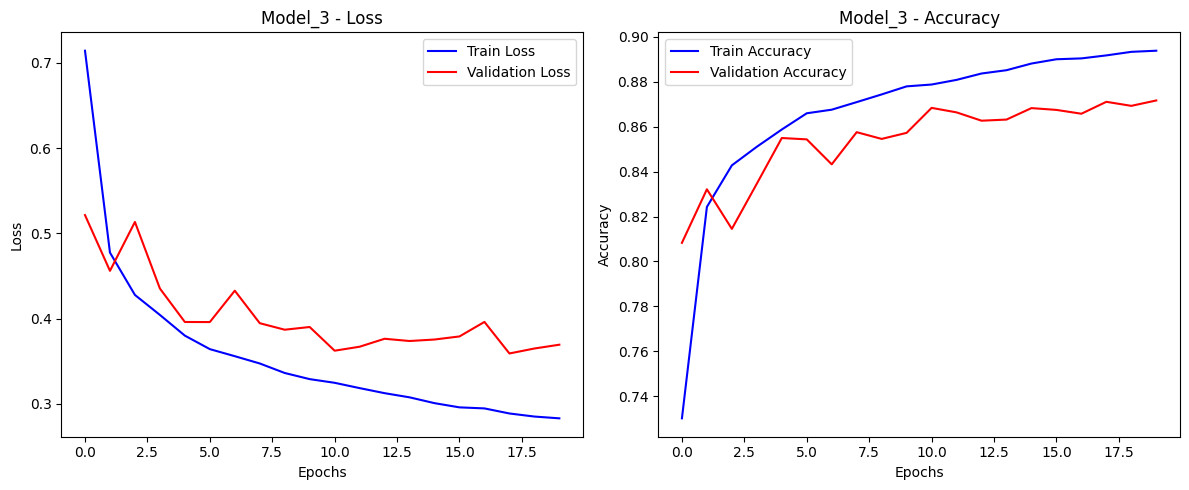

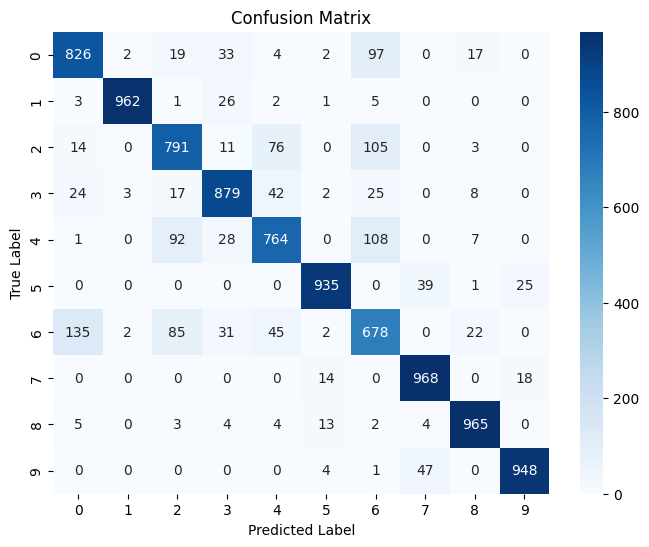

Accuracy: 87.16%, F1 Score: 0.8716
Training Model_3 with Learning Rate: 0.001
Epoch 1/20, Train Loss: 0.8341, Train Accuracy: 68.66%, Val Loss: 0.6448, Val Accuracy: 76.15%
Epoch 2/20, Train Loss: 0.5698, Train Accuracy: 78.95%, Val Loss: 0.5446, Val Accuracy: 79.99%
Epoch 3/20, Train Loss: 0.4882, Train Accuracy: 82.19%, Val Loss: 0.4974, Val Accuracy: 81.82%
Epoch 4/20, Train Loss: 0.4455, Train Accuracy: 83.68%, Val Loss: 0.4594, Val Accuracy: 83.25%
Epoch 5/20, Train Loss: 0.4166, Train Accuracy: 84.73%, Val Loss: 0.4663, Val Accuracy: 82.55%
Epoch 6/20, Train Loss: 0.3958, Train Accuracy: 85.41%, Val Loss: 0.4308, Val Accuracy: 84.29%
Epoch 7/20, Train Loss: 0.3751, Train Accuracy: 86.19%, Val Loss: 0.4065, Val Accuracy: 85.13%
Epoch 8/20, Train Loss: 0.3619, Train Accuracy: 86.79%, Val Loss: 0.3997, Val Accuracy: 85.43%
Epoch 9/20, Train Loss: 0.3492, Train Accuracy: 87.16%, Val Loss: 0.3868, Val Accuracy: 85.93%
Epoch 10/20, Train Loss: 0.3375, Train Accuracy: 87.59%, Val Loss: 

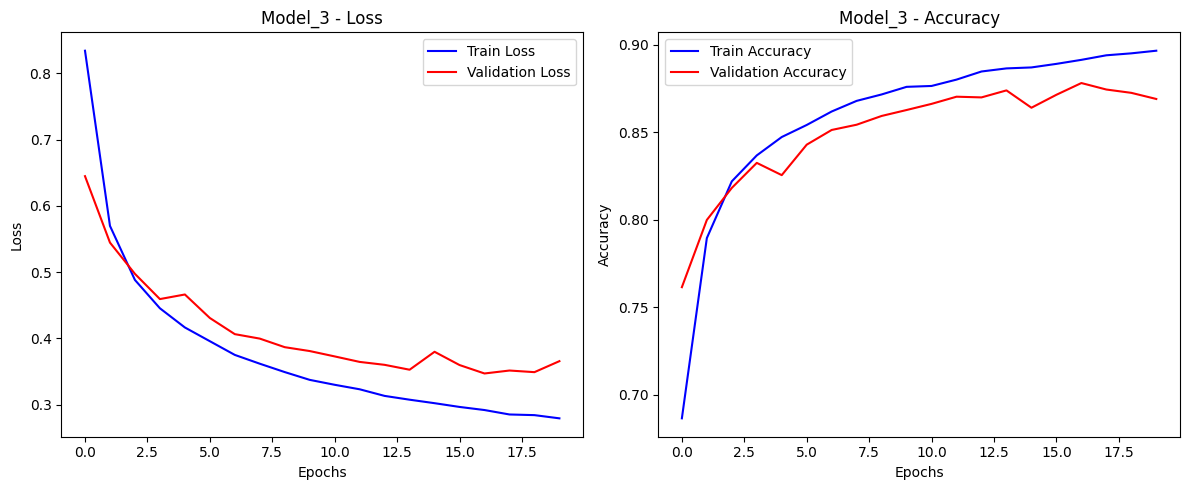

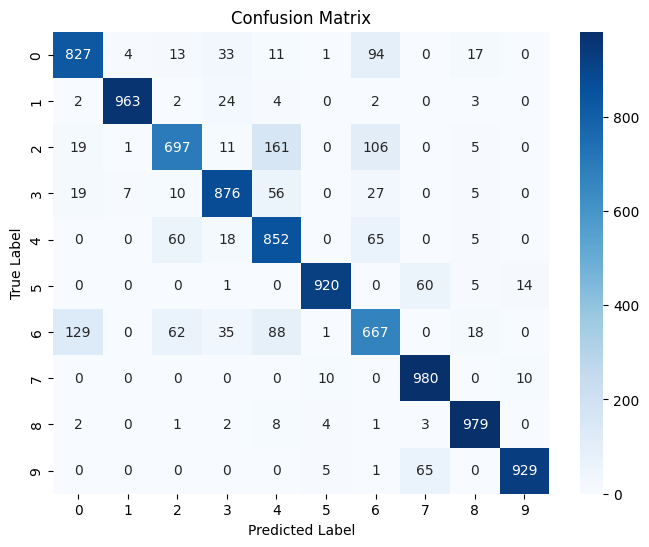

Accuracy: 86.90%, F1 Score: 0.8686
Training Model_3 with Learning Rate: 0.0005
Epoch 1/20, Train Loss: 0.9373, Train Accuracy: 64.88%, Val Loss: 0.7225, Val Accuracy: 74.47%
Epoch 2/20, Train Loss: 0.6520, Train Accuracy: 76.33%, Val Loss: 0.6376, Val Accuracy: 77.19%
Epoch 3/20, Train Loss: 0.5634, Train Accuracy: 79.43%, Val Loss: 0.5518, Val Accuracy: 79.99%
Epoch 4/20, Train Loss: 0.5085, Train Accuracy: 81.40%, Val Loss: 0.5286, Val Accuracy: 80.85%
Epoch 5/20, Train Loss: 0.4795, Train Accuracy: 82.55%, Val Loss: 0.4927, Val Accuracy: 82.08%
Epoch 6/20, Train Loss: 0.4556, Train Accuracy: 83.44%, Val Loss: 0.4833, Val Accuracy: 82.43%
Epoch 7/20, Train Loss: 0.4346, Train Accuracy: 84.10%, Val Loss: 0.4693, Val Accuracy: 82.59%
Epoch 8/20, Train Loss: 0.4182, Train Accuracy: 84.77%, Val Loss: 0.4421, Val Accuracy: 83.88%
Epoch 9/20, Train Loss: 0.4040, Train Accuracy: 85.21%, Val Loss: 0.4306, Val Accuracy: 84.16%
Epoch 10/20, Train Loss: 0.3913, Train Accuracy: 85.61%, Val Loss:

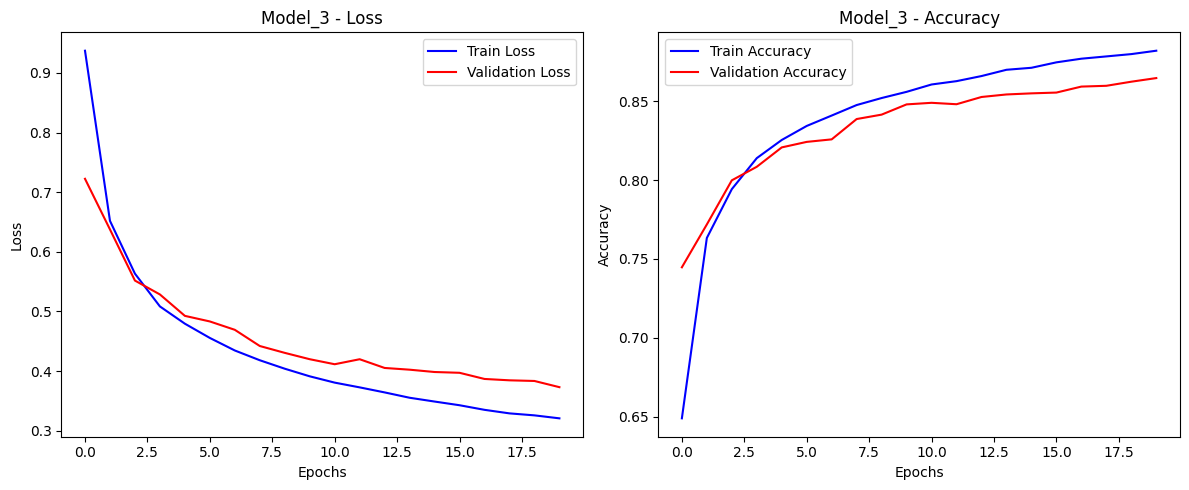

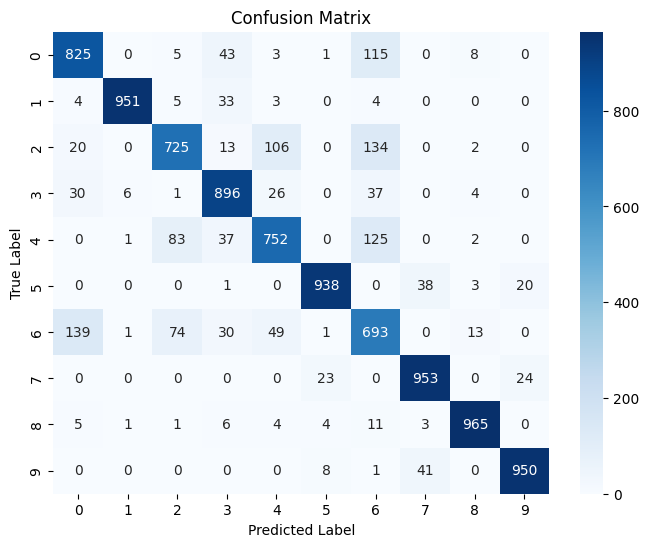

Accuracy: 86.48%, F1 Score: 0.8656
Training Model_3 with Learning Rate: 0.0001
Epoch 1/20, Train Loss: 1.3416, Train Accuracy: 51.08%, Val Loss: 0.9371, Val Accuracy: 64.13%
Epoch 2/20, Train Loss: 0.8495, Train Accuracy: 68.05%, Val Loss: 0.8094, Val Accuracy: 70.06%
Epoch 3/20, Train Loss: 0.7718, Train Accuracy: 70.94%, Val Loss: 0.7645, Val Accuracy: 71.80%
Epoch 4/20, Train Loss: 0.7325, Train Accuracy: 72.64%, Val Loss: 0.7369, Val Accuracy: 73.13%
Epoch 5/20, Train Loss: 0.7046, Train Accuracy: 74.06%, Val Loss: 0.7161, Val Accuracy: 74.35%
Epoch 6/20, Train Loss: 0.6808, Train Accuracy: 75.24%, Val Loss: 0.6933, Val Accuracy: 75.11%
Epoch 7/20, Train Loss: 0.6602, Train Accuracy: 76.17%, Val Loss: 0.6696, Val Accuracy: 76.10%
Epoch 8/20, Train Loss: 0.6418, Train Accuracy: 76.80%, Val Loss: 0.6533, Val Accuracy: 76.42%
Epoch 9/20, Train Loss: 0.6249, Train Accuracy: 77.48%, Val Loss: 0.6372, Val Accuracy: 77.07%
Epoch 10/20, Train Loss: 0.6079, Train Accuracy: 78.09%, Val Loss:

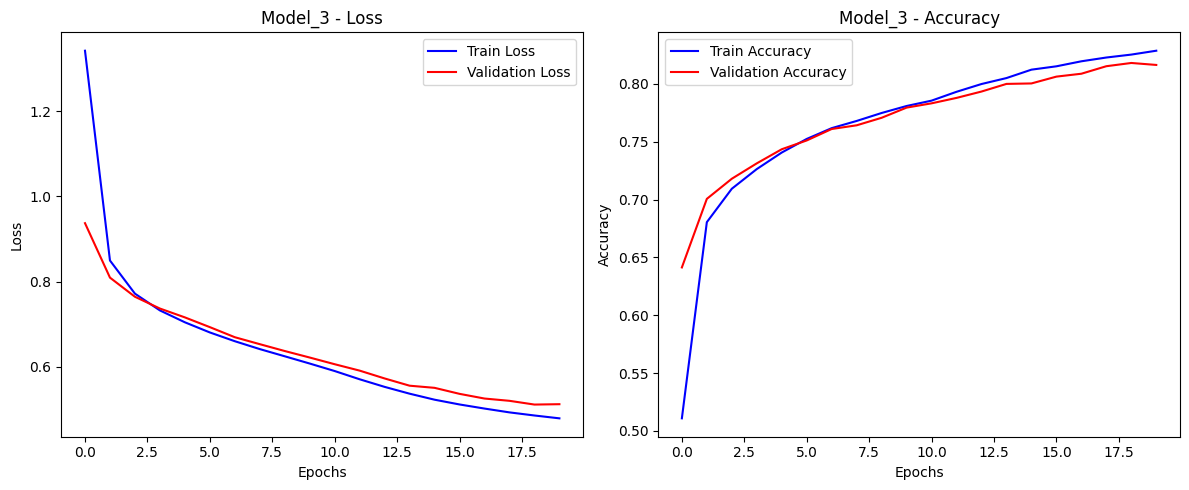

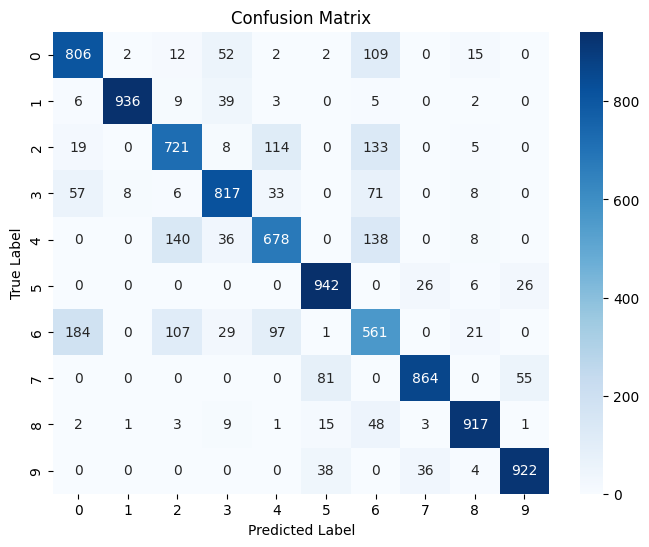

Accuracy: 81.64%, F1 Score: 0.8174
Best_Model: Model_1, Learning_Rate: 0.005


In [19]:
# Main Execution
X_train, Y_train, X_test, Y_test = load_data()

# Define the 3 models
models = [
    ('Model_1', [Dense(28*28, 256), ReLU(), Dense(256, 10), Softmax()]),
    ('Model_2', [Dense(28*28, 128), ReLU(), Dense(128, 256), ReLU(), Dense(256, 10), Softmax()]),
    ('Model_3', [Dense(28*28, 64), ReLU(), Dense(64, 128), ReLU(), Dense(128, 256), ReLU(), Dense(256, 10), Softmax()])
]

# Learning rates
learning_rates = [5e-3, 1e-3, 5e-4, 1e-4]
epochs = 20

best_score = 0.0
best_model = None
best_model_name = None
best_model_learning_rate = None

# Train each model with the different learning rates
for model_name, model_layers in models:
    for lr in learning_rates:
        print(f"Training {model_name} with Learning Rate: {lr}")
        # Recreate the model and re-initialize weights
        model = [Dense(layer.input_size, layer.output_size) if isinstance(layer, Dense) else layer for layer in model_layers]
        
        #train the model
        train_loss, val_loss, train_acc, val_acc = train(model, cross_entropy, X_train, Y_train, X_test, Y_test, epochs=epochs, learning_rate=lr)
        
        # Save the model
        #save_model(model, f'{model_name}_lr_{lr}')

        # Plot the loss and accuracy curves
        plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, model_name)

        # Evaluate the model
        accuracy, f1 = evaluate_model(model, X_test, Y_test)
        print(f"Accuracy: {accuracy * 100:.2f}%, F1 Score: {f1:.4f}")

        if f1 > best_score:
                best_score = f1
                best_model = model
                best_model_name = model_name
                best_model_learning_rate = lr

# store in pickle
import pickle
with open('model_1905027.pkl', 'wb') as f:
    # first clear all unnecessary values
    for layer in best_model:
        layer.input = None
        layer.output = None
    pickle.dump(best_model, f)

print(f"Best_Model: {best_model_name}, Learning_Rate: {best_model_learning_rate}")

In [20]:
# load the pickle file
with open('model_1905027.pkl', 'rb') as f:
    model = pickle.load(f)

C:\Users\huzza\AppData\Local\Temp\ipykernel_10008\666859072.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image).flatten() / 255.0  # Flatten and normalize to [0, 1]


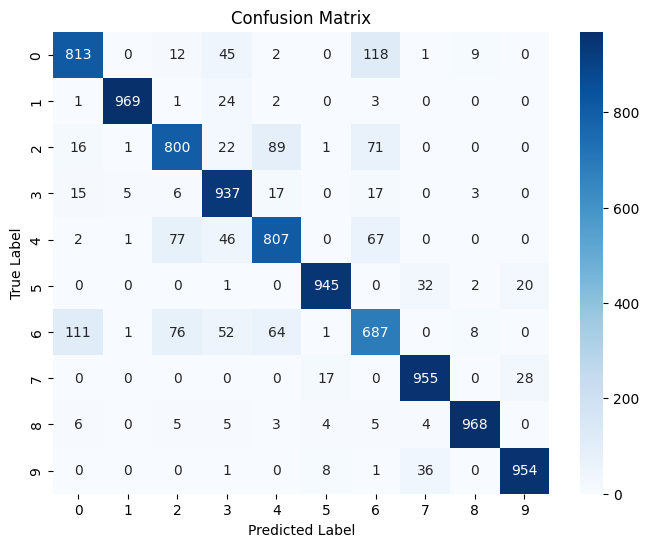

Accuracy: 88.35%, F1 Score: 0.8832


In [21]:
# Load the best model from the pickle file
def load_best_model(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model

# Preprocess function (same as used for training)
def preprocess(dataset):
    images = []
    labels = []
    for image, label in dataset:
        image = np.array(image).flatten() / 255.0  # Flatten and normalize to [0, 1]
        label_onehot = np.zeros(10)  # One-hot encoding
        label_onehot[label] = 1
        images.append(image)
        labels.append(label_onehot)

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load test data
def load_test_data():
    test_dataset = ds.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())
    X_test, Y_test = preprocess(test_dataset)
    return X_test, Y_test

# Accuracy, F1 Score, and Confusion Matrix Calculation with plotting
def evaluate_model(network, X_test, Y_test):
    Y_pred = []
    for i in range(0, len(X_test), 32):
        batch = X_test[i:i + 32]
        output = batch
        for layer in network:
            output = layer.forward(output)
        Y_pred.append(np.argmax(output, axis=1))
    Y_pred = np.concatenate(Y_pred)
    
    # Accuracy and F1 Score
    accuracy = accuracy_score(np.argmax(Y_test, axis=1), Y_pred)
    f1 = f1_score(np.argmax(Y_test, axis=1), Y_pred, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(np.argmax(Y_test, axis=1), Y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return accuracy, f1, cm

# Main execution for testing the model
def test_model():
    # Load the model
    best_model = load_best_model('model_1905027.pkl')
    
    # Load the test data
    X_test, Y_test = load_test_data()
    
    # Evaluate the model
    accuracy, f1, cm = evaluate_model(best_model, X_test, Y_test)
    print(f"Accuracy: {accuracy * 100:.2f}%, F1 Score: {f1:.4f}")

# Run the testing function
test_model()